# Wikipedia user activity analysis

In this project we will analyze Wikipedia users activity logs. The analysis is based on Wikimedia Foundation user behaviours dataset that can be found [here](https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016).

## 1. Frame the problem

The analysed dataset contains event logging data which is used by Wikimedia to track a variety of performance and usage metrics to help them build various metrics and make data-driven strategic decisions.

The aim of this analysis is to answer the following questions:
1. What is the daily overall clickthrough rate: the proportion of search sessions where the user clicked on one of the results displayed? How does it change day-to-day? How does day-to-day clickthrough rate vary between the groups?
2. Which results - in terms of position of the result link selected by the user on the search result page - do people tend to try first? How does it change day-to-day?
3. What is the daily overall zero results rate: the proportion of searches that yielded 0 results? How does it change day-to-day? How does it vary between the groups?
4. What is the relationship between the number of pages visited in one session and the session length?

That means that we will build two metrics needed to answer these questions: clickthrough rate and zero results rate. With them we will analyse different aspects of user activity.

## 2. Get the data

We will use a dataset published by Wikimedia Foundation that can be found [here](https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016).

The dataset comes from a tracking schema that is used in Wikimedia Foundation for assessing user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this schema to estimate how long users stay on the pages they visit. The dataset contains over a week of event logging data.


| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |


An event's action field can have following values:
* `searchResultPage`: when a new search is performed and the user is shown a SERP.
* `visitPage`: when the user clicks a link in the results.
* `checkin`: when the user has remained on the page for a pre-specified amount of time.

Example session can look like this:

|uuid                             |      timestamp|session_id       |group |action           | checkin|page_id          | n_results| result_position|
|:--------------------------------|:--------------|:----------------|:-----|:----------------|-------:|:----------------|---------:|---------------:|
|4f699f344515554a9371fe4ecb5b9ebc | 20160305195246|001e61b5477f5efc |b     |searchResultPage |      NA|1b341d0ab80eb77e |         7|              NA|
|759d1dc9966353c2a36846a61125f286 | 20160305195302|001e61b5477f5efc |b     |visitPage        |      NA|5a6a1f75124cbf03 |        NA|               1|
|77efd5a00a5053c4a713fbe5a48dbac4 | 20160305195312|001e61b5477f5efc |b     |checkin          |      10|5a6a1f75124cbf03 |        NA|               1|
|42420284ad895ec4bcb1f000b949dd5e | 20160305195322|001e61b5477f5efc |b     |checkin          |      20|5a6a1f75124cbf03 |        NA|               1|
|8ffd82c27a355a56882b5860993bd308 | 20160305195332|001e61b5477f5efc |b     |checkin          |      30|5a6a1f75124cbf03 |        NA|               1|
|2988d11968b25b29add3a851bec2fe02 | 20160305195342|001e61b5477f5efc |b     |checkin          |      40|5a6a1f75124cbf03 |        NA|               1|

This user's search query returned 7 results, they clicked on the first result, and stayed on the page between 40 and 50 seconds.

Let's load the data.

In [1]:
import pandas as pd

In [2]:
activity_df = pd.read_csv("datasets/events_log.csv")

Now we can check how the data looks like.

In [3]:
activity_df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


We can see that we have several features for each recorded session. Some of them have text values and some are numerical. Let's dig deeper into that dataset structure and properties.

In [4]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null float64
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: float64(4), object(5)
memory usage: 27.5+ MB


We can see that dataset contains 400165 event logging data records in total.

In case of `checkin`, `n_results` and `result_position` we deal with missing values. In case of `checkin` feature `NaN` values are result of users's `action` value: some `action` types does not have `checkin` values. We will leave it the way it is. Similar in case of `n_results`: only searchResultPage `action` value sessions have `n_results` values different than `NaN`. Again we will leave it as it is. And similar situation with `result_position`: `NaN` values mean here that the event log was not a result of opening a page from search result.

`uuid`, `session_id`, `group`, `action`, `page_id` attributes have text values.

`timestamp`, `checkin`, `n_results`, `result_position` are numerical attributes.

Actually `timestamp` attribute values should be converted to `datetime` data format for easier use like timestamps comparison. Let's do it then. 


In [5]:
date_str = activity_df["timestamp"].astype(int).astype(str)
activity_df["timestamp"] = pd.to_datetime(date_str, format="%Y%m%d%H%M%S")

In [6]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400165 entries, 0 to 400164
Data columns (total 9 columns):
uuid               400165 non-null object
timestamp          400165 non-null datetime64[ns]
session_id         400165 non-null object
group              400165 non-null object
action             400165 non-null object
checkin            223824 non-null float64
page_id            400165 non-null object
n_results          136234 non-null float64
result_position    230482 non-null float64
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 27.5+ MB


Now the data looks correct and ready for further analysis.

Let's now dig deeper into numerical attributes values.

In [7]:
activity_df.describe()

,checkin,n_results,result_position
count,223824.000000,136234.000000,230482.000000
mean,97.190382,13.210109,2.992798
std,104.593714,13.271104,38.557292
min,10.000000,0.000000,1.000000
25%,20.000000,2.000000,1.000000
50%,50.000000,20.000000,1.000000
75%,150.000000,20.000000,2.000000
max,420.000000,500.000000,4103.000000


`checkin` attribute mean is meaningless taking into account how values are gathered. But we can check its maximal value - the longest session took 420 seconds. 

`n_results` attribute mean value of 13.21 means that on average user gets that many results per search. Of course maximal value is very large, reaching 500. Later on we will analyse this attribute distribution to make more out of this data.

`result_position` mean value tells us that the link that user was looking for was on average the third in search results (not so good scenario). However the median value tells us it was first (good scenario). Also the max value here seems to be an error. Also here we will later on dig into this attribute distribution to get to know what is going on here.

Let's see values our categorical attributes can have. 

Of course `uuid`, `session_id` and `page_id` have unique values. `group` and `action` are categorical.

In [8]:
activity_df["group"].unique()

array(['b', 'a'], dtype=object)

In [9]:
activity_df["action"].unique()

array(['searchResultPage', 'checkin', 'visitPage'], dtype=object)

All looks good. We are ready for data exploration.

## 3. Explore the data

We will perform some basic exploratory analysis to see how the data behaves in general sense, what are main tendencies or what are the relations between variables. We will also build our metrics here and try to answer our project questions (posed at the begining of the analysis).

We will start by general exploration. Let's look at numerical values distributions.

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1158fd160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115a4d5c0>]], dtype=object)

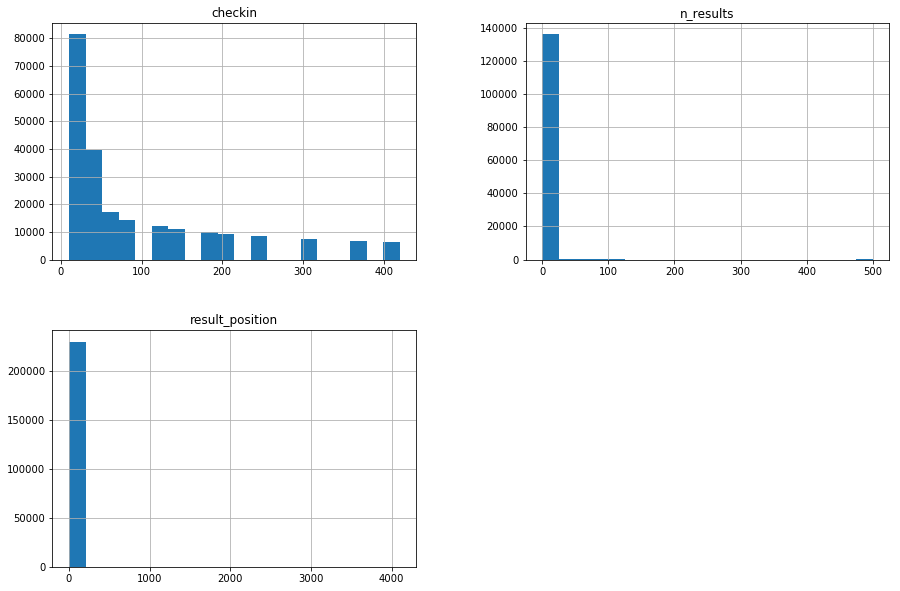

In [11]:
activity_df.hist(bins=20, figsize=(15, 10))

Looking at `checkin` values - which tell us how many seconds the page has been open for - we see that the vast majority of the distribution is concentrated aroung 0-100 secodns values. Only around 8000 of pages reachech 400 seconds sessions. The distribution looks really realitistic.

`n_results` (number of search hits returned to the user) distribution looks suspicious. As we mentioned earlier it is low likely that user will get 500 hits after the query or even if it is likely for some query it looks like outlier that we should get rid of before further analysis. Let's see how many large values like that we have. To classify as outlier let's use statistical rule: outlier if value is greater than 75% quantile value plus 1.5 of interquantile range.

In [12]:
iqr_n_results = activity_df["n_results"].quantile(0.75) - activity_df["n_results"].quantile(0.25)
outlier_threshold_n_results = activity_df["n_results"].quantile(0.75) + iqr_n_results
outlier_threshold_n_results

38.0

In [13]:
len(activity_df[activity_df["n_results"] > outlier_threshold_n_results])

360

We see that we have only - considering 400165 data records - 360 values above our outlier threshold which stretch our distribution to the right. The best thing for further analysis will be droping these outlier data records from our dataset. We also need to remember to keep `NaN` values here since they are also informative.

In [14]:
import numpy as np

activity_df = activity_df[(activity_df["n_results"] <= outlier_threshold_n_results) | (activity_df["n_results"].isnull())]
len(activity_df)

399805

Now it is time to look at `result_position` (the position of the visited page's link on the search engine results page ) distribution. As we saw previously its max value is 4103 and the distribution on the plot looks unrealistic. Either these value is an error or it is really unlikely outlier. Let's repeat the procedure - detecting outliers in the distribution - we did for `n_results`.

In [15]:
iqr_result_position = activity_df["result_position"].quantile(0.75) - activity_df["result_position"].quantile(0.25)
outlier_threshold_result_position = activity_df["result_position"].quantile(0.75) + iqr_result_position
outlier_threshold_result_position

3.0

Here our IQR based threshold is really small - that would result in large number of values being discarder. Let's then be really non-restrictive here and set threshold value to be 50. We are talking about the position of the visited page's link on the search engine results page. Chances for it to be more then 40 are really small. Let's see how small.

In [16]:
manual_outlier_threshold = 30
len(activity_df[activity_df["result_position"] > manual_outlier_threshold])

940

There are only 940 data records with values of `result_position` above 30 among 400165 data records. Probability of getting these values is 0.002 - very low probability. That means that for the sake of data clarity we can drop these outlier results.

In [17]:
activity_df = activity_df[(activity_df["result_position"] <= manual_outlier_threshold) | (activity_df["result_position"].isnull())]
activity_df = activity_df.reset_index(drop=True)
len(activity_df)

398865

Now all looks good. Let's again look at our numerical attributes distributions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c3e7da0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10fc5cac8>]], dtype=object)

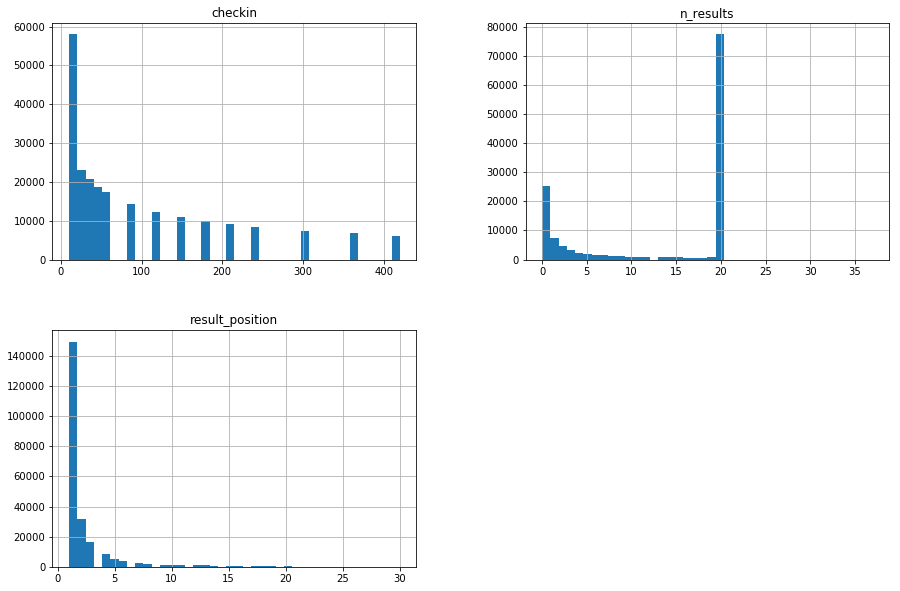

In [18]:
activity_df.hist(bins=40, figsize=(15, 10))

Now we are able to tell something more about our numerical attributes distributions. `n_results` (the number of hits returned to the user.) histogram, previously unreadable, now shows clearly what is going on. We see that vast majority of user searches get 20 results. It seems that data is somehow capped at this point - maybe by search meachanism - to that value which is indicated by this large peak in the middle of the distribution. This could be checked with engineers who created data logging mechanism - why is that happening?

Also we can see that there is quite a lot of searches resulting in one result. That could mean that the user looke for something really specific and search was so specific that it returned only one answer. The question to ask here would be whether it was the answer the user was looking for - namely whether she or he clicked it. This could be checked later on.

There are also in-between values. On one hand there are search results where user's query returned more than one but less then 20 results. And that is perfectly normal for searches which are less specific. On the other hand there are searches which resulted in more than 20 results. And there are around few hundreds of them meaning that they are somehow strange why they are happening so rarely or at all if it turned out that search results are in fact capped at max 20 results.

Going back to `result_position` - it now looks clear and seems to be fine. We can see that most of searches ends up with user clicking on the first link and if not the first five results are next to choose. Searches with clicked results of above result number 5 of the result list are marginal in number. That tells us that users find what they are looking for right in the to of their search result page. That is really impressive.

To finish this part of exploration we can also check our categorical attributes distributions.

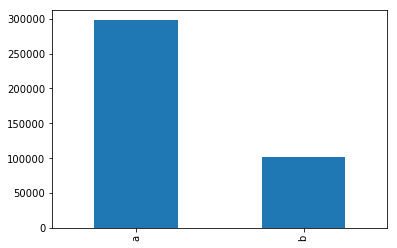

In [19]:
activity_df["group"].value_counts().plot(kind='bar')

We can see that vast majority of users belong to group A (300,000 vs. 100,000). So probably group B is experiment test group.

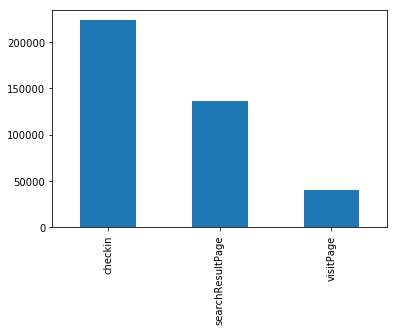

In [20]:
activity_df["action"].value_counts().plot(kind='bar')

Let's see what is going on in `action` (when the user has remained on the page for a pre-specified amount of time) attribute distribution. We have here kind of obvious fact that the majority of the user logs will be `checkin`  value (when the user has remained on the page for a pre-specified amount of time). Users spend most of the time reading the Wikipedia articles. More surprising can be quite a lot of `searchResultPage` (when a new search is performed and the user is shown a SERP). That means that users also use Wikipedia search feature really actively. However there is really low number of `visitPage` events (when the user clicks a link in the results). Theoretically every search result page view could end up clicking on one of the result. However since number of `visitPage` events is much lower comparing to `searchResultPage` means there are a lot of searches that does not end with clicking on any of the results - probably refining the query anr running search again. The question that could be asked here is how large is the number of searches which does not result in user clicking on any of the result. That could be infered indirectly by checking the difference between `searchResultPage` events number and `visitPage`. Let's do it.

In [21]:
val_counts = activity_df["action"].value_counts()
val_counts

checkin             223187
searchResultPage    135874
visitPage            39804
Name: action, dtype: int64

In [22]:
val_counts["visitPage"] / val_counts["searchResultPage"]

0.29294787818125617

That would mean that 96070 out of 135874 `searchResultPage` did not end with `visitPage` event meaning that 70% of all searches end up with not finding what the user was looking for and either droping the search or repeating the search with more detailed or modified query. That, comparing to above analysis of `result_position` attribute values is not so optimistic. All in all it means that if after searching something on Wikipedia user finds correct result and clicks on results page link, the result is most likely in the top 5 links. However in 70% of search cases user does not click any of returned result. That is not so effective as it looked before. We could further analyse this problem by searching for such (multiple failed searches) patterns in user logs events or use this value as one of the metrics we will construct to measure users behavior by investigating how this values changes over time. Will focus on it in next stage of this analysis.

We are now ready to start answering questions we posed in the begining.

## 3.1 What is the daily overall clickthrough rate? How does it change day-to-day? How does day-to-day clickthrough rate vary between the groups?

We define clickthrough rate as the proportion of search sessions where the user clicked on one of the results displayed. 

To answer these questions lets first check how example session looks like.

In [23]:
activity_df[activity_df["session_id"] == "78245c2c3fba013a"].sort_values(by="timestamp")

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
85006,36af0358f25155fb8978d5f50737d432,2016-03-01 10:38:46,78245c2c3fba013a,b,visitPage,NaN,2f0e04bd56649f43,NaN,3.0
80131,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10.0,2f0e04bd56649f43,NaN,3.0
31531,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20.0,2f0e04bd56649f43,NaN,3.0
468,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30.0,2f0e04bd56649f43,NaN,3.0
17056,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40.0,2f0e04bd56649f43,NaN,3.0


We can see that there is a pattern in `action` attribute we are looking for: `searchResultPage` value followed by `visitPage` value meaning that user performed search and then clicked on one of the results. Cases like this are the search sessions where the user clicked on one of the results displayed we want to get for metric we create.

For completeness - the other case would be `searchResultPage` followed by another `searchResultPage` meaning that did not find anything interesting to visit or just end of session meaning that user simply left/closed the webpage without doing anything.

Let's create new attribute by adding `clicked_through` marking each searchResultPage with 1 if it was followed by page visit (meaning that user clicked on one of the search result) and 0 otherwise. For action types other then `searchResultPage` we will put NaN value in this column. This will allow us to later easily agregate this value for calculating our metric in different time aspects and for users groups.

It is worth mentioning that user logs are recorded in the database/dataset not in time of occurence order. Above data table is sorted by `timestamp` to show how events occurence order. But when we look at these time ordered event data we can see that indices are not in order meaning that index order is different than timestamp order. We will have to keep in mind when analysing the data.

Let's first go manually through above session and analyze first `searchResultPage`. First we will select search page display event we decided to analyze.

In [24]:
search_page = activity_df.iloc[0]
search_page

uuid               00000736167c507e8ec225bd9e71f9e5
timestamp                       2016-03-01 10:38:42
session_id                         78245c2c3fba013a
group                                             b
action                             searchResultPage
checkin                                         NaN
page_id                            cbeb66d1bc1f1bc2
n_results                                         5
result_position                                 NaN
Name: 0, dtype: object

Next we will group all user logs by `session_id`. Thanks to that we will be able to quickly (hashtable) look for specific session for give search result page instead of iterating through whole data frame over and over again.

In [25]:
session_id_grouped = activity_df.groupby("session_id")

Now from our grouped events let's select the ones from the same `session_id` as our selected `searchResultPage` event log and ordered by timestamps of events.

In [26]:
ordered_search_session_events = session_id_grouped.get_group(search_page["session_id"]).sort_values(by="timestamp")
ordered_search_session_events

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
85006,36af0358f25155fb8978d5f50737d432,2016-03-01 10:38:46,78245c2c3fba013a,b,visitPage,NaN,2f0e04bd56649f43,NaN,3.0
80131,33922e14b6bb5e27823481a3c44ed462,2016-03-01 10:38:56,78245c2c3fba013a,b,checkin,10.0,2f0e04bd56649f43,NaN,3.0
31531,14601aeb2bf058af9380c1644e606e24,2016-03-01 10:39:06,78245c2c3fba013a,b,checkin,20.0,2f0e04bd56649f43,NaN,3.0
468,004690364c695f04b5d045913e1bdf7c,2016-03-01 10:39:16,78245c2c3fba013a,b,checkin,30.0,2f0e04bd56649f43,NaN,3.0
17056,0af62216356759fea26313e155f70809,2016-03-01 10:39:26,78245c2c3fba013a,b,checkin,40.0,2f0e04bd56649f43,NaN,3.0


Finally let's keep only events AFTER our analyzed `searchResultPage` and check what type is the first event right after it.

In [27]:
after_search_events = ordered_search_session_events[ordered_search_session_events["timestamp"] > search_page["timestamp"]]
after_search_events.iloc[0]

uuid               36af0358f25155fb8978d5f50737d432
timestamp                       2016-03-01 10:38:46
session_id                         78245c2c3fba013a
group                                             b
action                                    visitPage
checkin                                         NaN
page_id                            2f0e04bd56649f43
n_results                                       NaN
result_position                                   3
Name: 85006, dtype: object

That event `action` value is `visitPage`. That tells us that next event log right after our analysed `searchResultPage` event was an `visitPage` event meaning that user clicked on one of the search result links - third link to be exact!

Let's now streamline this whole process for the whole dataframe and for each of the user logs. Processing all 398865 data logs can take some time (e.g. minutes depending on the machine) but it is worthwhile.

In [28]:
def get_searches_click_through(df):
    session_id_grouped = df.groupby("session_id")
    search_pages = df[df["action"] == "searchResultPage"]
    
    clicked_through = np.empty(len(df))
    clicked_through[:] = np.nan
    
    for idx, search_page in search_pages.iterrows():
        ordered_search_session_events = session_id_grouped.get_group(search_page["session_id"]).sort_values(by="timestamp")
        after_search_events = ordered_search_session_events[ordered_search_session_events["timestamp"] > search_page["timestamp"]]
        
        if len(after_search_events) > 0 and after_search_events.iloc[0]["action"] == "visitPage":
            clicked_through[idx] = 1
        else:
            clicked_through[idx] = 0
    
    return clicked_through


In [29]:
activity_df["clicked_through"] = get_searches_click_through(activity_df)

In [30]:
activity_df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,clicked_through
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,1.0
1,00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,0.0
2,00003bfdab715ee59077a3670331b787,2016-03-02 14:53:05,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2016-03-02 22:27:01,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,NaN
4,000050cbb4ef5b42b16c4d2cf69e6358,2016-03-02 09:50:23,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,NaN


We now have all the information needed to fully answer our questions.

### What is the overall clickthrough rate?

In [31]:
def get_clickthrough_rate(df):
    return df[df["action"] == "searchResultPage"]["clicked_through"].sum() / len(df[df["action"] == "searchResultPage"])

In [32]:
get_clickthrough_rate(activity_df)

0.24212137715824955

The overall clickthrough rate is at 0.2421 level meaning that about 24.21% of overall searches ends with user clicking on a one of returned links. Let's remember that we estimated it in exploratory stage to be 0.2929. What happened? Let's look at overall number `searchResultPage` events.

In [33]:
len(activity_df[activity_df["action"] == "searchResultPage"])

135874

The same value as when we analysed the bar chart for `action` attribute. What about number of searches which ended with user clicking one of the search results?

In [34]:
activity_df[activity_df["action"] == "searchResultPage"]["clicked_through"].sum()

32898.0

There is overall 39804 `visitPage` events in the dataset. Why only 32898 `searchResultPage` were followed by `visitPage` event? We have to keep in mind that there are `visitPage` events which are not a result of choosing a link from `searchResultPage` (example below) and therefore they are not included in our metrics final number. 

In [35]:
activity_df[activity_df["session_id"] == "66a1ccf936a2aca1"].sort_values(by="timestamp")

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,clicked_through
325025,d054879b4a5e5f9da1540a7a91118894,2016-03-01 01:19:17,66a1ccf936a2aca1,a,searchResultPage,NaN,b15e97730eaf187a,20.0,NaN,0.0
314788,c9caef4c00ab56d18f2f10a1e3e5557d,2016-03-01 01:19:38,66a1ccf936a2aca1,a,searchResultPage,NaN,2a047288b1d046c5,20.0,NaN,1.0
445,00425c87f40657cea53c79b268f89cb2,2016-03-01 01:19:51,66a1ccf936a2aca1,a,visitPage,NaN,9676425891e0715a,NaN,1.0,NaN
774,007a2ab683465b948273454d16edc10a,2016-03-01 01:20:01,66a1ccf936a2aca1,a,checkin,10.0,9676425891e0715a,NaN,1.0,NaN
296997,be4d89ccac8351ebad91d8ed9d79f84d,2016-03-01 01:20:11,66a1ccf936a2aca1,a,checkin,20.0,9676425891e0715a,NaN,1.0,NaN
192645,7b7fb22549755977941090ae6fceafd8,2016-03-01 01:20:20,66a1ccf936a2aca1,a,visitPage,NaN,d5e063af052ee843,NaN,NaN,NaN
17611,0b5244ac92f558b283673e03baa9740c,2016-03-01 01:20:29,66a1ccf936a2aca1,a,checkin,10.0,d5e063af052ee843,NaN,NaN,NaN
49765,20147b1f27af50458ce1e376e0c53419,2016-03-01 01:20:39,66a1ccf936a2aca1,a,checkin,20.0,d5e063af052ee843,NaN,NaN,NaN
313450,c8ef25e9042e5857acb2ae453233f528,2016-03-01 01:20:49,66a1ccf936a2aca1,a,checkin,30.0,d5e063af052ee843,NaN,NaN,NaN
385510,f757cbd598bd52e0a487be64c006f70a,2016-03-01 01:20:59,66a1ccf936a2aca1,a,checkin,40.0,d5e063af052ee843,NaN,NaN,NaN


### How does it change day-to-day?

In [36]:
activity_grouped_day = activity_df.groupby(activity_df["timestamp"].dt.date)

In [72]:
clickthrough_rate_by_day = activity_grouped_day.apply(get_clickthrough_rate)
clickthrough_rate_by_day

timestamp
2016-03-01    0.237016
2016-03-02    0.236421
2016-03-03    0.243554
2016-03-04    0.246378
2016-03-05    0.245370
2016-03-06    0.251062
2016-03-07    0.240754
2016-03-08    0.239400
dtype: float64

No we can see what is the daily overall clickthrough rate and how it varies. Let's see some statitistics values.

In [38]:
clickthrough_rate_by_day.describe()

count    8.000000
mean     0.242494
std      0.005034
min      0.236421
25%      0.238804
50%      0.242154
75%      0.245622
max      0.251062
dtype: float64

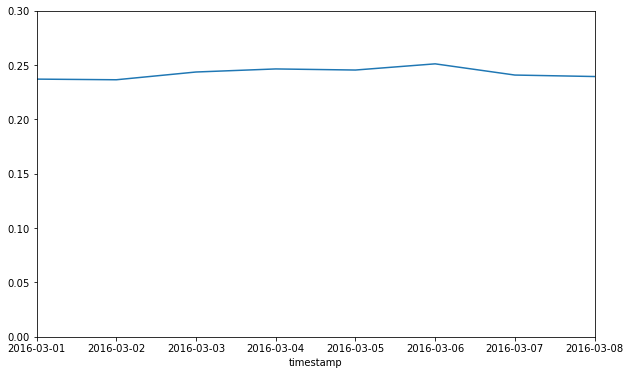

In [39]:
clickthrough_rate_by_day.plot(figsize=(10, 6), ylim=(0, 0.3))

It varies a bit from day to day but in general it keeps close to the mean with rather small standard deviation. 

###  How does day-to-day clickthrough rate vary between the groups?

There are two groups we want to perform the test for: `a` and `b`.

In [83]:
activity_df["group"].unique()

array(['b', 'a'], dtype=object)

Let analyze how overall clickthrough rate varies between these two groups.

In [99]:
activity_grouped_group = activity_df.groupby("group")

In [100]:
activity_grouped_group.apply(get_clickthrough_rate)

group
a    0.285817
b    0.151387
dtype: float64

For group `a` the overall clickthrough rate is 0.2858 and for group `b` it is 0.1514. So it is much lower in group `b`.

How does the differences between groups look in day-to-day clickthrough rates?

In [101]:
a_activity_grouped_day = activity_grouped_group.get_group("a").groupby(activity_df["timestamp"].dt.date)
a_clickthrough_rate_by_day = a_activity_grouped_day.apply(get_clickthrough_rate)
a_clickthrough_rate_by_day

timestamp
2016-03-01    0.291271
2016-03-02    0.284054
2016-03-03    0.293234
2016-03-04    0.284004
2016-03-05    0.283518
2016-03-06    0.297609
2016-03-07    0.274643
2016-03-08    0.279100
dtype: float64

In [102]:
b_activity_grouped_day = activity_grouped_group.get_group("b").groupby(activity_df["timestamp"].dt.date)
b_clickthrough_rate_by_day = b_activity_grouped_day.apply(get_clickthrough_rate)
b_clickthrough_rate_by_day

timestamp
2016-03-01    0.119689
2016-03-02    0.126208
2016-03-03    0.131655
2016-03-04    0.168031
2016-03-05    0.174036
2016-03-06    0.165500
2016-03-07    0.172714
2016-03-08    0.159213
dtype: float64

We can see what values were building calculated earlier groups mean clickthrough value. Let's plot individual daily clickthrough rates.

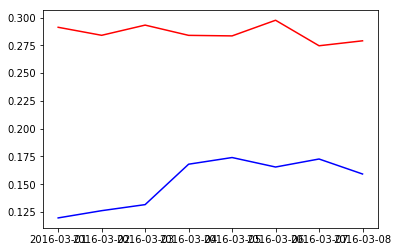

In [103]:
plt.plot(a_clickthrough_rate_by_day, color="red")
plt.plot(b_clickthrough_rate_by_day, color="blue")

Clickthrough rates are much smaller for group b. To tell whether the effect is significant we need to perform hypothesis testing.

In [104]:
from scipy import stats

stats.ttest_ind(a_clickthrough_rate_by_day, b_clickthrough_rate_by_day)

Ttest_indResult(statistic=15.962836121999828, pvalue=2.2285145983034117e-10)

The resulted t-statistic is very high meaning that the difference between two variables divided by pooled standard error is really big - we are far from t distibution central point. As a result p-value is really small with significance level of p < .001. That means that `b` group day-to-day clickthrough rate is significantly lower than `a` group day-to-day clickthrough.

That means that the effect of the treatment applied to group b is significant and resulting clickthrough rate is much lower.

## 3.2 Which results do people tend to try first? How does it change day-to-day?

We will analyse this in terms of position of the result link selected by the user on the search result page.

To answer that question we first need to select user logs with atribute `action` value `visitPage`. For these we will find information about which results do people tend to try first. Let's start by selecting `visitPage` user logs.

In [42]:
visit_page_df = activity_df[activity_df["action"] == "visitPage"]
visit_page_df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,clicked_through
21,0002d29d932e539993a6b1720340a993,2016-03-01 01:03:16,b2b413b1432226f8,a,visitPage,NaN,96113a4c8ea50856,NaN,3.0,NaN
29,0003edb9988255be80e800a83c8bcbe6,2016-03-02 17:29:04,7d3304f88a44cb78,a,visitPage,NaN,cde6f03a9e537a06,NaN,1.0,NaN
57,000892cfabc25873b2e5b9da2ef8d734,2016-03-06 10:47:25,761d4fbd6aa1c867,a,visitPage,NaN,44012022574420e3,NaN,1.0,NaN
77,000b3be6a1d651518d622641ad3de358,2016-03-03 20:50:07,92891186ca96fd5d,a,visitPage,NaN,2e4cc16c7886447e,NaN,1.0,NaN
100,000e24fe8b6f5efa909bf7b7f940cbc3,2016-03-03 03:39:48,fbf64f1d9b0558bf,a,visitPage,NaN,9288e20d598e94c2,NaN,NaN,NaN


### Which results do people tend to try first?

To answer let's analyse `result_position` attribute values for opened pages.

In [43]:
visit_page_df["result_position"].describe()

count    33776.000000
mean         2.353772
std          3.060881
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         30.000000
Name: result_position, dtype: float64

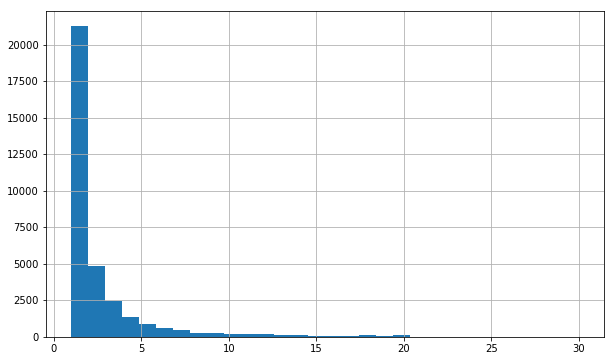

In [44]:
visit_page_df["result_position"].hist(bins=30, figsize=(10, 6))

We can see that overall users by far tend to try first result first. The distribution is positevely skewed, so even though the mean here is 2.35, the better central tendency measure will be median value which is as we expected 1. 

### How does it change day-to-day?

To answer this question we will group our vist page data logs by date and check how `result_position` values behave from day to day.

In [45]:
visit_page_grouped = visit_page_df.groupby(visit_page_df["timestamp"].dt.date)

Let's first analyse the mean for each day.

In [46]:
visit_page_grouped["result_position"].mean()

timestamp
2016-03-01    2.285040
2016-03-02    2.368892
2016-03-03    2.439841
2016-03-04    2.248388
2016-03-05    2.349441
2016-03-06    2.341346
2016-03-07    2.365614
2016-03-08    2.421235
Name: result_position, dtype: float64

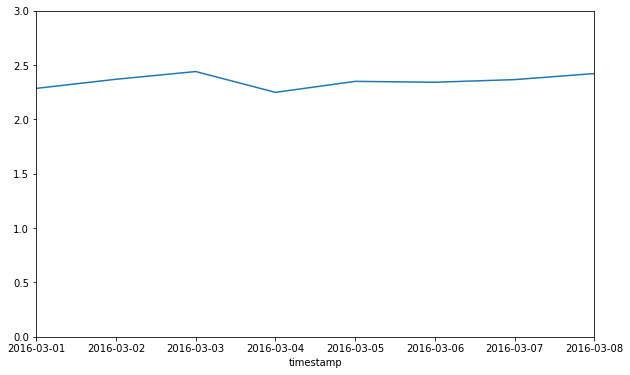

In [47]:
visit_page_grouped["result_position"].mean().plot(figsize=(10, 6), ylim=(0, 3.0))

The mean result users tend to try first on average changes very little from day to day.

Let's also see the daily median value of opened search result position.

In [48]:
visit_page_grouped["result_position"].median()

timestamp
2016-03-01    1.0
2016-03-02    1.0
2016-03-03    1.0
2016-03-04    1.0
2016-03-05    1.0
2016-03-06    1.0
2016-03-07    1.0
2016-03-08    1.0
Name: result_position, dtype: float64

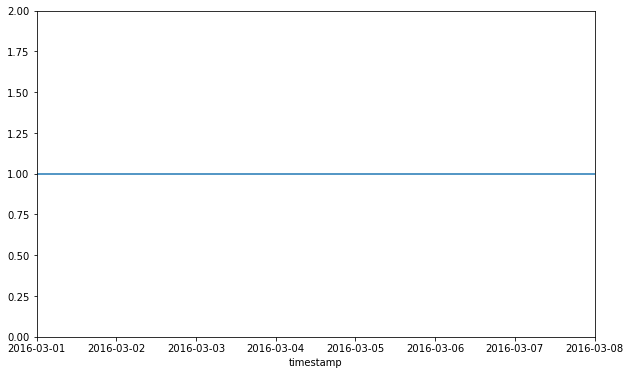

In [49]:
visit_page_grouped["result_position"].median().plot(figsize=(10, 6), ylim=(0, 2.0))

The median value - clearly a better measure in skewed distribution like this one - is stable from day to day and equal to 1 meaning that people in general tend to open first result in search page.

## 3.3 What is the daily overall zero results rate? How does it change day-to-day? How does it vary between the groups?

We define here the overall zero results rate as the proportion of searches that yielded 0 results.

### What is the daily overall zero results rate? 

In [50]:
def get_zeroresults_rate(df):
    return len(df[(df["action"] == "searchResultPage") & (df["n_results"] == 0)]) / len(df[(df["action"] == "searchResultPage")])

In [51]:
get_zeroresults_rate(activity_df)

0.1849286839277566

The overall zero results rate is 0.1849 meaning that 18% of all searches ends with zero results.

### How does it change day-to-day?

In [52]:
activity_grouped_day = activity_df.groupby(activity_df["timestamp"].dt.date)

In [53]:
zeroresults_rate_by_day = activity_grouped_day.apply(get_zeroresults_rate)
zeroresults_rate_by_day

timestamp
2016-03-01    0.188248
2016-03-02    0.190378
2016-03-03    0.180064
2016-03-04    0.182021
2016-03-05    0.185337
2016-03-06    0.176374
2016-03-07    0.182278
2016-03-08    0.193990
dtype: float64

Above are daily overall zero results rates. Let's see some statictics and plot of overall zero results rate daily values.

In [54]:
zeroresults_rate_by_day.describe()

count    8.000000
mean     0.184836
std      0.005797
min      0.176374
25%      0.181532
50%      0.183807
75%      0.188780
max      0.193990
dtype: float64

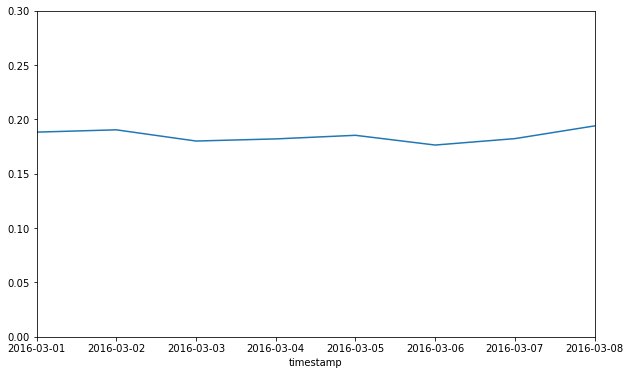

In [55]:
zeroresults_rate_by_day.plot(figsize=(10, 6), ylim=(0, 0.3))

The mean value for daily overall zero results rate for 0.184836 and from day to day it varies rather minimally wit hstandard deviation of 0.005. This can also be seen on plot of daily overall zero results rate. 

### How does it vary between the groups?

In [56]:
activity_grouped_group = activity_df.groupby("group")

In [57]:
activity_grouped_group.apply(get_zeroresults_rate)

group
a    0.184300
b    0.186233
dtype: float64

The difference between the overall zero results rate for group `a` and `b` is minimal: `a` has 0.1843 value and `b` has 0.1862 value.

# Test for significance.

## 3.4 What is the relationship between the number of pages visited in one session and the session length?

We define the session length tp be approximately the time between the first event and the last event in a session.

We'll start answering this question by getting all the sessions by grouping user logs by `session_id`. Then for each session we want to know two things. First, how long the session was where session length is the time measured in seconds between the first event and the last event in a session. Second, how many `visitPage` actions occured in the session. The number of pages visited is marked by the `visitPage` value in `action` attribute.
We will iterate through sessions calculating above values for each of them.

The result will be a new dataframe containing the two values for each session with `session_id` as index value.

We need to make one assumption here. If session contains only one event we have not means to check how much time user spent during that session (we have just the begining of the session) so we decide that such session will count as 0 seconds length.

In [58]:
def get_sessions_visits_lengths(df):
    sessions_grouped = df.groupby("session_id")
    visits_lengths = []
    for session_id, group in sessions_grouped:
        sorted_group = group.sort_values(by="timestamp")
        pages_visited = get_visits_number(sorted_group)
        session_length = get_session_length(sorted_group.iloc[0]["timestamp"], sorted_group.iloc[-1]["timestamp"])
        visits_lengths.append((session_id, pages_visited, session_length))
    visits_lengths_df = pd.DataFrame(data=visits_lengths, columns=["session_id", "pages_visited", "session_length"])
    visits_lengths_df = visits_lengths_df.set_index("session_id")
    return visits_lengths_df

In [59]:
def get_session_length(t1, t2):
    return (t2 - t1).total_seconds()

def get_visits_number(df):
    return df["action"].value_counts().get("visitPage", 0)

In [60]:
visits_lengths_df = get_sessions_visits_lengths(activity_df)

Let's have a quick look at the data we agregated.

In [61]:
visits_lengths_df.head()

,pages_visited,session_length
session_id,,
0000cbcb67c19c45,0,0.0
0001382e027b2ea4,1,303.0
0001e8bb90445cb2,1,435.0
000216cf18ae1ab1,0,58.0
000527f711d50dfc,0,0.0


In [62]:
visits_lengths_df.describe()

,pages_visited,session_length
count,68021.000000,68021.000000
mean,0.585172,153.346687
std,1.187060,2198.053740
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,15.000000
75%,1.000000,138.000000
max,51.000000,504879.000000


When we look at `session_length` max value there is something strange: a session that lasted 504879 seconds. That is almost 6 days! It also looks like error or outlier considering median and third quartile values being 15 and 138 seconds. Let's see it more closely.



In [63]:
visits_lengths_df.max()

pages_visited         51.0
session_length    504879.0
dtype: float64

In [64]:
visits_lengths_df.idxmax()

pages_visited     8338dc907ea63e2d
session_length    8cf57f4f99f96220
dtype: object

In [65]:
visits_lengths_df.loc["8cf57f4f99f96220"]

pages_visited         14.0
session_length    504879.0
Name: 8cf57f4f99f96220, dtype: float64

In [66]:
activity_df[activity_df["session_id"] == "8cf57f4f99f96220"].sort_values(by="timestamp")

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,clicked_through
228154,9236c96c2f655ba0a5b8f617946bbd14,2016-03-02 16:49:05,8cf57f4f99f96220,a,searchResultPage,NaN,50c2bacb1b7b57f4,20.0,NaN,1.0
244821,9cefc92b83f75274a8716b83560ce92a,2016-03-02 16:49:12,8cf57f4f99f96220,a,visitPage,NaN,c12f1bf15c75266b,NaN,1.0,NaN
244818,9ceec8b2e8c051d0b8a88f3a4cdacae8,2016-03-02 16:49:22,8cf57f4f99f96220,a,checkin,10.0,c12f1bf15c75266b,NaN,1.0,NaN
296374,bdddf211bc235b1f97aff92ee22dea46,2016-03-02 16:49:32,8cf57f4f99f96220,a,checkin,20.0,c12f1bf15c75266b,NaN,1.0,NaN
122029,4e810b28250c595c8380daacda0aa96c,2016-03-02 16:49:42,8cf57f4f99f96220,a,checkin,30.0,c12f1bf15c75266b,NaN,1.0,NaN
43650,1c2b8391917c5340a9aade5ac93d7f53,2016-03-02 16:49:55,8cf57f4f99f96220,a,checkin,40.0,c12f1bf15c75266b,NaN,1.0,NaN
344588,dcfce3b08f6c5b4999dd9878915d2a99,2016-03-02 16:50:13,8cf57f4f99f96220,a,checkin,50.0,c12f1bf15c75266b,NaN,1.0,NaN
249765,a01bf61f78dd504e82e63d6b2bda318a,2016-03-02 16:50:25,8cf57f4f99f96220,a,checkin,60.0,c12f1bf15c75266b,NaN,1.0,NaN
89880,39d8acaa7ee159dc99f36052c192da01,2016-03-02 16:50:56,8cf57f4f99f96220,a,checkin,90.0,c12f1bf15c75266b,NaN,1.0,NaN
269151,ac80b23ec20d585393d8ffcfa0abe041,2016-03-02 16:51:30,8cf57f4f99f96220,a,checkin,120.0,c12f1bf15c75266b,NaN,1.0,NaN


This is really strange session. The `session_id` is unique and all events have the same id so they belong to the same session. The strange thing is the fact that sometimes the periods between user logs are very long like here:

```
330343	d3c528fa87ca5b748cbd35e8150328eb	2016-03-06 15:21:12	8cf57f4f99f96220	a	checkin	40.0	0246925f38373a7c	NaN	1.0	NaN
340309	da3868affd46568282e041607569a00d	2016-03-07 19:47:49	8cf57f4f99f96220	a	searchResultPage	NaN	8930bf7471a7c3a0	20.0	NaN	1.0
```

This is over 24 hours between last `checkin` (user visiting a page) and subsequent `searchResultPage` (user visiting a search page) log. This looks most likely like logging system error and session like this should be discarded before further analysis. 

There are multiple data records with such strange long period of inactivity in a session. For further analysis let's drop the sessions above 5000 seconds. They make 61 sessions data records out of 68021 sessions in total. They seem to be outlier values or technical errors - unrealistic in practical usage situations. We make this cutoff level a bit arbitrary here but it seems reasonable to set outlier rejection level like that considering what we found in data and real use cases. It would be even lower if we consider the `> Q3 + 1.5 * IQR` outlier threshold.

In [67]:
visits_lengths_df = visits_lengths_df[visits_lengths_df["session_length"] <= 5000]

In [68]:
visits_lengths_df.describe()

,pages_visited,session_length
count,67960.000000,67960.000000
mean,0.582858,125.434035
std,1.174208,250.412205
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,15.000000
75%,1.000000,137.000000
max,51.000000,4991.000000


Now `session_length` statistical parameter look more consise and realitic.

We are now ready to analyze the relationship between number of pages visited in a session to session length. Let's 
start with the correlation (Person's r) between `pages_visited` and `session_length`.

In [69]:
visits_lengths_df.corr()

,pages_visited,session_length
pages_visited,1.000000,0.503959
session_length,0.503959,1.000000


We can see that there is quite distinct positive correlation between number of pages visited and the session length. Let's now see scatter plot of both variables.

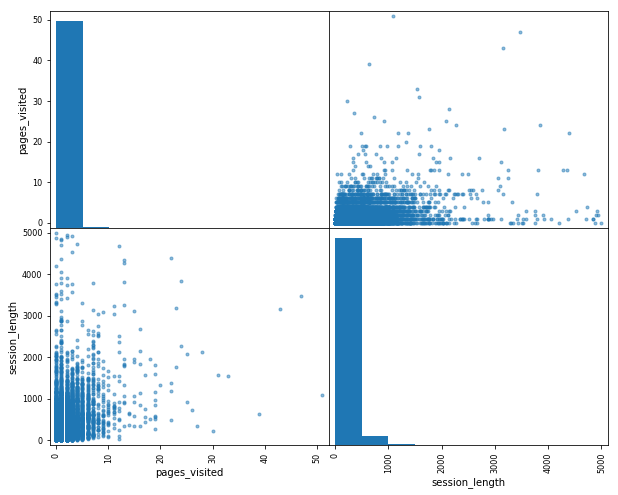

In [70]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(visits_lengths_df, figsize=(10, 8));

Let's make a close-up scatter plot of both variables.

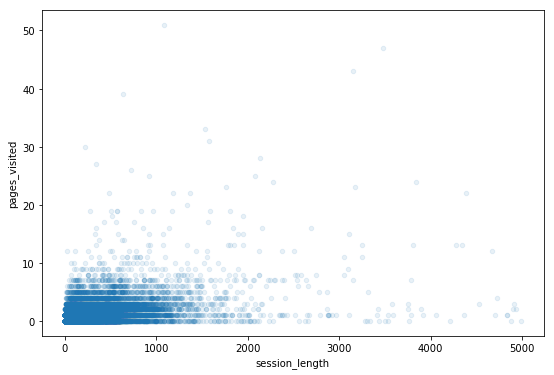

In [71]:
visits_lengths_df.plot(kind="scatter", x="session_length", y="pages_visited", alpha=0.1, figsize=(9, 6))

As we can see there is a positive corelation between session length and number of pages visited and it is quite strong with 0.504 value. The result is kind of intiutive and tells us that when the user spends more time on platform she/he tends to visit more pages. 

# Fit regression line here.

## 5. Executive summary

Summarize findings in an executive summary.